# Grover FoM Conditional Run Demo

This notebook mirrors the CHSH conditional workflow, but evaluates the new `GroverFigureOfMerit`. We:

- build the Grover FoM specification;
- run the FoM through `run_conditionally` with pass/fail callbacks;
- inspect the resulting `QonsciousResult`; and
- visualize the counts from the FoM evaluation or the follow-up circuit.

In [1]:
from __future__ import annotations

from pprint import pprint

import matplotlib.pyplot as plt

from qiskit import QuantumCircuit

from qonscious import run_conditionally
from qonscious.actions import QonsciousCallable
from qonscious.adapters import AerSamplerAdapter
from qonscious.checks import MeritComplianceCheck
from qonscious.foms import GroverFigureOfMerit

SHOTS = 4000
NUM_TARGETS = 2
N_OVERRIDE = 3
RANDOM_SEED = 1234
LAMBDA_WEIGHT = 0.2
MU_WEIGHT = 0.4
SCORE_THRESHOLD = 0.15
MCX_MODE = "noancilla"


In [2]:
backend_adapter = AerSamplerAdapter()

grover_fom = GroverFigureOfMerit(
    num_targets=NUM_TARGETS,
    lam=LAMBDA_WEIGHT,
    mu=MU_WEIGHT,
    shots=SHOTS,
    mcx_mode=MCX_MODE,
    seed=RANDOM_SEED,
    n_override=N_OVERRIDE,
)

def grover_score_over(threshold: float):
    def decision(fom_result):
        if fom_result is None:
            return False
        return fom_result["properties"]["score"] > threshold

    return decision


def build_follow_up_circuit(num_qubits: int) -> QuantumCircuit:
    circuit = QuantumCircuit(num_qubits, num_qubits)
    circuit.h(range(num_qubits))
    circuit.cx(0, range(1, num_qubits))
    circuit.measure(range(num_qubits), range(num_qubits))
    return circuit


def on_pass(backend_adapter, fom_results, **kwargs):
    fom_result = fom_results[0]
    score = fom_result["properties"]["score"]
    targets = fom_result["properties"]["targets"]
    print("Grover FoM passed threshold!")
    print(f"Score: {score:.4f}")
    print(f"Marked states: {targets}")

    follow_up = build_follow_up_circuit(fom_result["properties"]["num_qubits"])
    result = backend_adapter.run(follow_up, shots=kwargs.get("shots", SHOTS))
    print("Follow-up circuit finished running.")
    return result


def on_fail(backend_adapter, fom_results, **kwargs):
    fom_result = fom_results[0]
    score = fom_result["properties"]["score"]
    print("Grover FoM below threshold.")
    print(f"Score: {score:.4f}")
    return None


grover_check = MeritComplianceCheck(
    figure_of_merit=grover_fom,
    decision_function=grover_score_over(SCORE_THRESHOLD),
)


In [3]:
print("Running conditional workflow with Grover FoM...\n")
qonscious_result = run_conditionally(
    backend_adapter=backend_adapter,
    checks=[grover_check],
    on_pass=QonsciousCallable(on_pass),
    on_fail=QonsciousCallable(on_fail),
    shots=SHOTS,
)

pprint(qonscious_result)


Running conditional workflow with Grover FoM...

Grover FoM below threshold.
Score: -0.0394
{'condition': 'fail',
 'experiment_result': None,
 'figures_of_merit_results': [{'experiment_result': {'backend_properties': {'name': 'qiskit_aer.primitives.SamplerV2'},
                                                     'counts': {'000': 508,
                                                                '001': 493,
                                                                '010': 465,
                                                                '011': 530,
                                                                '100': 460,
                                                                '101': 510,
                                                                '110': 492,
                                                                '111': 542},
                                                     'raw_results': PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<sh

In [4]:
fom_result = qonscious_result["figures_of_merit_results"][0]
experiment_result = qonscious_result["experiment_result"] or fom_result["experiment_result"]

print("\nFoM properties:")
pprint(fom_result["properties"])

print("\nExperiment counts:")
pprint(experiment_result["counts"])



FoM properties:
{'lambda': 0.2,
 'mcx_mode': 'noancilla',
 'mu': 0.4,
 'num_qubits': 3,
 'probabilities': {'000': 0.127,
                   '001': 0.12325,
                   '010': 0.11625,
                   '011': 0.1325,
                   '100': 0.115,
                   '101': 0.1275,
                   '110': 0.123,
                   '111': 0.1355},
 'score': -0.03935000000000005,
 'search_space_size': 8,
 'shots': 4000,
 'targets': ['110', '111']}

Experiment counts:
{'000': 508,
 '001': 493,
 '010': 465,
 '011': 530,
 '100': 460,
 '101': 510,
 '110': 492,
 '111': 542}


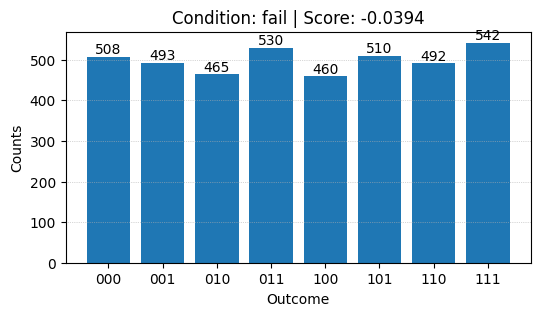

In [5]:
counts = experiment_result["counts"]
labels = sorted(counts)
values = [counts[label] for label in labels]

fig, ax = plt.subplots(figsize=(6, 3))
bars = ax.bar(labels, values)
ax.set_xlabel("Outcome")
ax.set_ylabel("Counts")
ax.set_title(
    f"Condition: {qonscious_result['condition']} | Score: {fom_result['properties']['score']:.4f}"
)
ax.grid(True, axis="y", linestyle=":", linewidth=0.5)

for bar, value in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), value, ha="center", va="bottom")

plt.show()
